In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Question 1 

Importing images from their correspounding files 

In [2]:
image1 = cv.imread("1134110.jpg")
image2 = cv.imread("pexels-david-bartus-963278.jpg")

Resizing the first image because it was way 2 big

In [3]:
image1 = cv.resize(image1, (0,0),fx=0.2,fy=0.2)

In [4]:
image1.shape

(576, 1024, 3)

Resizing the second image to have the same size as the first one 

In [5]:
image2 = cv.resize(image2, (image1.shape[1], image1.shape[0]))

Creating butter lowpass filter incase of extracting low frequency data from the images to do this i used butter method that has been implemented in scipy with lowpass argument 

In [6]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(img, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    image = filtfilt(b, a, img)
    return image

Creating butter highpass filter incase of extracting hihg frequency data from the images to do this i used butter method that has been implemented in scipy with high pass argument 

In [7]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(img, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    image = filtfilt(b, a, img)
    return image

Creating hybrid image by extracting low frequency data from the first image and extracting high frequency data from the second image and then sum them up to get hybrid illusion  

In [8]:
def Hybrid_image(image1, image2, sampling_freq=120, cutoff_high=10, cutoff_low=30):
    image1 = cv.cvtColor(image1, cv.COLOR_BGR2GRAY)
    image2 = cv.cvtColor(image2, cv.COLOR_BGR2GRAY)

    image1_lowfreq = butter_lowpass_filter(image1, cutoff_low, sampling_freq)
    iamge2_highfreq = butter_highpass_filter(image2, cutoff_high, sampling_freq)
    hybrid_img = image1 + image2
    return hybrid_img

In [9]:
hybrid_img = Hybrid_image(image1, image2, 120, 50, 40)

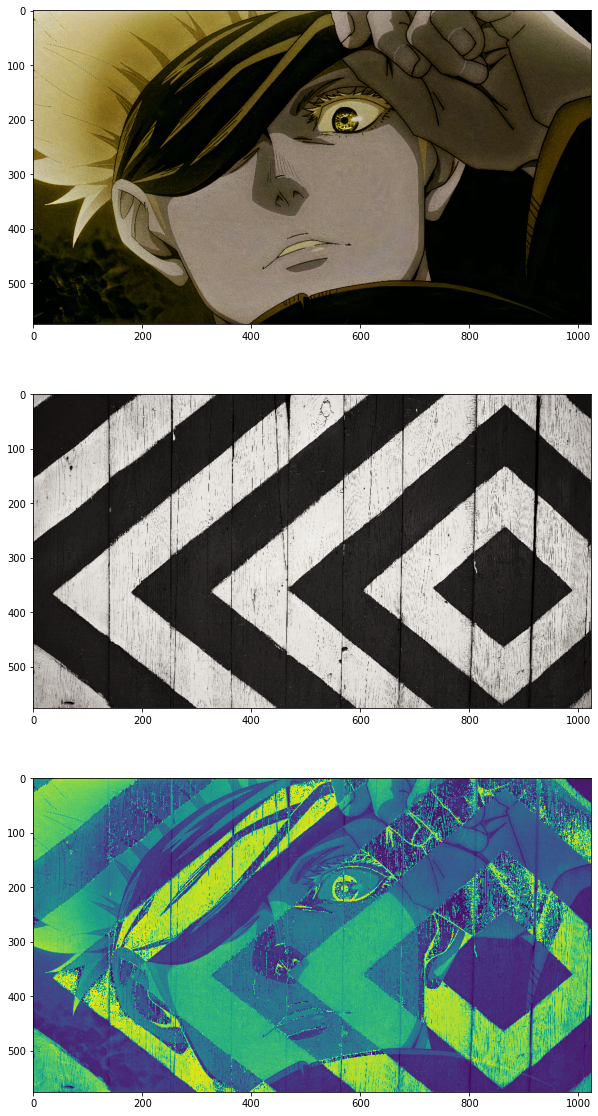

In [10]:
fig, ax = plt.subplots(3, 1)
fig.set_figheight(20)
fig.set_figwidth(10)
ax[0].imshow(image1)
ax[1].imshow(image2)
ax[2].imshow(hybrid_img)

In [58]:
cv.imshow("image 1 low frequency", hybrid_img)
cv.waitKey(0)
cv.destroyAllWindows()

# Question 2 

In [7]:
import glob
import re

In [11]:
url = "NISTSpecialDatabase4GrayScaleImagesofFIGS/sd04/png_txt"
images = glob.glob(url + '/**/*.png', recursive=True)
info = glob.glob(url + '/**/*.txt', recursive=True)

## Coding morphological preprocessing 

In [12]:
def preprocessing(image, th, kernel = np.ones((3,3), np.uint8)):
    gray_scale = cv.cvtColor(image, cv.COLOR_BGR2GRAY)                                 # convert original image to gray scal image 
    _, binarized = cv.threshold(gray_scale, th, maxval=255, type=cv.THRESH_BINARY)     # convert gray scaled image into binary image
    closed = cv.morphologyEx(binarized, cv.MORPH_CLOSE, kernel)                        # apply closing on the binarized image 
    return closed

In [13]:
raw_image = cv.imread(images[0])

In [14]:
kernel = np.ones((3,3), np.uint8)

imgs = []
for image in images:
    image = cv.imread(image)
    image = preprocessing(image, 120, kernel)
    imgs.append(image)

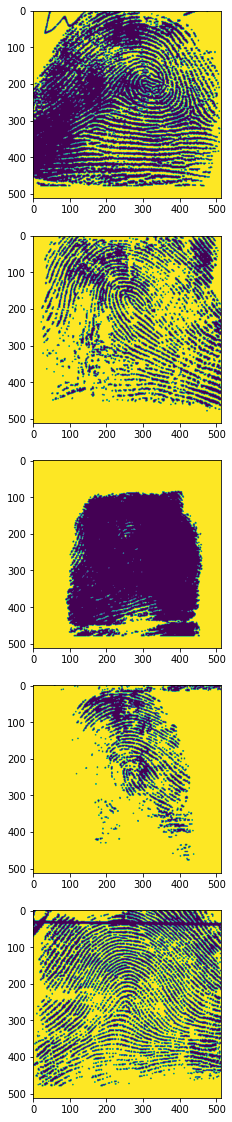

In [15]:
fig, ax = plt.subplots(5, 1)
fig.set_figwidth(15)
fig.set_figheight(20)
for i in range(5):
    ax[i].imshow(imgs[i])

## Edge extraction 

In [16]:
edges = []
for image in imgs:
    edges.append(cv.Canny(image, 100, 200))

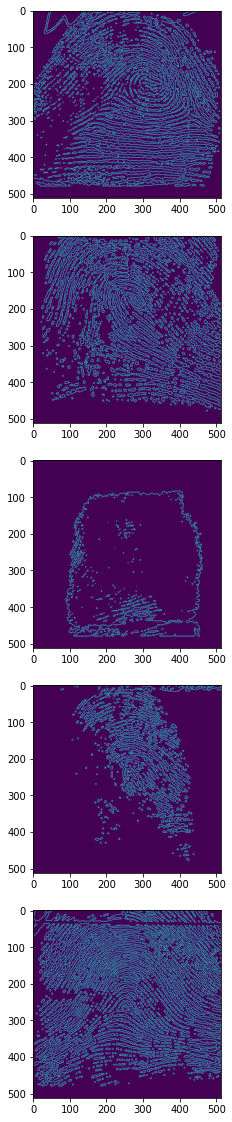

In [17]:
fig, ax = plt.subplots(5, 1)
fig.set_figwidth(15)
fig.set_figheight(20)
for i in range(5):
    ax[i].imshow(edges[i])

### Steps of the estimate_fingerprint_orientation() function in detail and their describtion
- blurred = cv2.GaussianBlur(image, (5, 5), 0): This applies Gaussian blur to the input image in order to reduce noise. Blurring helps to smooth out an image by averaging the pixel values in the neighborhood of each pixel. It is useful for reducing noise and removing small details that are not relevant to the problem at hand.

- _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU): This line applies thresholding to the blurred image using Otsu's method. Thresholding is a technique used to create binary images from grayscale images by setting pixels above or below a certain threshold to either black or white. Otsu's method is an algorithm used to automatically determine the optimal threshold value for separating foreground and background pixels in an image. The result is a binary image with the fingerprint region in white and the background in black.

- contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE): This finds the contours in the binary image created in the previous step. Contours are simply the boundaries of objects in an image. In this case, the contours correspond to the outline of the fingerprint region in the binary image.

- cnt = max(contours, key=cv2.contourArea): This selects the largest contour in the image, which corresponds to the fingerprint region. Since fingerprints are typically the largest object in an image, selecting the largest contour is a reasonable assumption.

- x,y,w,h = cv2.boundingRect(cnt): This computes a bounding rectangle around the selected contour. The bounding rectangle is a rectangle that completely encloses the contour and has the minimum possible area. This step helps to isolate the fingerprint region from the rest of the image.

- cropped = image[y:y+h, x:x+w]: This crops the input image to the bounding box region computed in the previous step. The result is an image containing only the fingerprint region, which makes it easier to compute the orientation of the fingerprint.

- moments = cv2.moments(cnt): This computes the moments of the selected contour. Moments are a set of statistical values that describe the shape of objects in an image. They can be used to compute various properties of an object, such as its centroid or orientation.

- hu_moments = cv2.HuMoments(moments): This computes the Hu moments of the selected contour using the moments computed in the previous step. The Hu moments are a set of seven scale-invariant moments that are commonly used in pattern recognition and image analysis. They are particularly useful for fingerprint recognition because they are insensitive to rotation, translation, and scaling.

- theta = -np.arctan2(hu_moments[1], hu_moments[0]) * 180 / np.pi: This computes the orientation angle of the fingerprint using the first two Hu moments. The orientation angle represents the direction of the major axis of the fingerprint ridge pattern. It is calculated as the arctangent of the second Hu moment divided by the first Hu moment.

- center = (w//2, h//2): This computes the center point of the bounding box region. The center point is used later to create the rotation matrix.

- M = cv2.getRotationMatrix2D(center, int(theta), 1.0): This creates a rotation matrix based on the estimated orientation angle and the center point of the bounding box region. The rotation matrix is a 2x3 matrix that can be used to rotate an image by a given angle around a specified point.

- return M: This returns the rotation matrix computed in the previous step, which can be used to rotate the original image to align the fingerprint ridge pattern with a vertical or horizontal axis.

In [18]:
class FingerprintClassifier:
    
    def __init__(self):
        self.sample_rotation_matrices = []
        self.class_labels = []
        
    def add_sample(self, fingerprint, class_label):
        rotation_matrix = self.get_rotation_matrix(fingerprint)
        self.sample_rotation_matrices.append(rotation_matrix)
        self.class_labels.append(class_label)
        
    def classify(self, new_fingerprint):
        new_rotation_matrix = self.get_rotation_matrix(new_fingerprint)
        similarities = []
        for sample_rot in self.sample_rotation_matrices:
            similarity = np.sum(np.abs(sample_rot - new_rotation_matrix))
            similarities.append(similarity)
        min_similarity_idx = np.argmin(similarities)
        return self.class_labels[min_similarity_idx]
    
    def get_rotation_matrix(self, image):
        # Perform Gaussian blur to reduce noise
        blurred = cv.GaussianBlur(image, (5, 5), 0)

        # Threshold the image to create a binary image
        _, thresh = cv.threshold(blurred, 0, 255, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

        # Find the contours in the binary image
        contours, _ = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

        # Assume that the largest contour corresponds to the fingerprint
        cnt = max(contours, key=cv.contourArea)

        # Create a bounding box around the fingerprint
        x,y,w,h = cv.boundingRect(cnt)

        # Crop the image to the bounding box region
        cropped = image[y:y+h, x:x+w]

        # Compute the orientation of the fingerprint using the Hu moments
        moments = cv.moments(cnt)
        hu_moments = cv.HuMoments(moments)
        theta = -np.arctan2(hu_moments[1], hu_moments[0]) * 180 / np.pi

        # Compute the rotation matrix
        center = (w//2, h//2)
        M = cv.getRotationMatrix2D(center, int(theta), 1.0)

        # Return the rotation matrix
        return M

In [ ]:
def extract_label(file_name):
    file = open(file_name, "r")

    contents = file.read()
    pattern = r"Class:\s+(\w)"

    match = re.findall(pattern, contents)
    file.close()
    return match[0]

The methodology of this classification is based on using rotation matrices as features for fingerprint recognition. The FingerprintClassifier class is implemented to contain necessary functions and variables required for the task. The class has an init function that initializes empty lists for sample rotation matrices and class labels. The add_sample function takes a fingerprint and its class label, calculates the rotation matrix using the get_rotation_matrix function, and adds it to the list of sample rotation matrices along with the corresponding class label. The classify function takes a new fingerprint, calculates the rotation matrix using the get_rotation_matrix function, computes the sum of absolute differences between the new rotation matrix and each of the sample rotation matrices, and returns the class label corresponding to the minimum similarity value.

In [20]:
classifier = FingerprintClassifier()

sample_1 = edges[0]
sample_2 = edges[1]
sample_3 = edges[2]
sample_4 = edges[3]
sample_5 = edges[4]

classifier.add_sample(sample_1, extract_label(info[0]))
classifier.add_sample(sample_2, extract_label(info[1]))
classifier.add_sample(sample_3, extract_label(info[2]))
classifier.add_sample(sample_4, extract_label(info[3]))
classifier.add_sample(sample_5, extract_label(info[4]))

new_fingerprint = edges[5]
predicted_class = classifier.classify(new_fingerprint)

In [21]:
print(f"predicted label is {predicted_class} and real class is {extract_label(info[5])}")

predicted label is W and real class is W
